# Dynamics via acceleration maps

In [372]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analysis import analysis

mu_factor = 6  # conversion to microns
min_factor = 8  # conversion to minutes
n_stats = 500  # delta between each recorded observation
dt = n_stats * 0.002 * min_factor / 60  # dt between each recorded observation, in hr


#### Load

In [373]:
from glob import glob

pkl_files = sorted(glob("data/raw_singleState*"))
list(zip(range(len(pkl_files)), pkl_files))

[(0, 'data/raw_singleState_D0.01_Req3.5.pkl'),
 (1, 'data/raw_singleState_D0.1_Req3.5.pkl'),
 (2, 'data/raw_singleState_D0.5_Req3.5.pkl')]

In [374]:
global_pos = pd.read_pickle(pkl_files[0])
global_pos.rename(columns={"grid id": "gid", "run id": "rid"}, inplace=True)
print(
    f"Loaded data with configuration: \n\t - D = {global_pos.D.unique()}\n\t - Req = {global_pos.R_eq.unique()}"
)

# POSITIONS ARE IN MICRONS
global_pos.x *= mu_factor
global_pos.y *= mu_factor
global_pos["timestamp[hr]"] = global_pos.index * dt

global_pos


Loaded data with configuration: 
	 - D = [0.01]
	 - Req = [3.5]


,x,y,D,R_eq,gid,rid,timestamp[hr]
0,75.000000,150.000000,0.01,3.5,463,45,0.000000
1,75.139496,151.768477,0.01,3.5,463,45,0.133333
2,75.152929,153.556778,0.01,3.5,463,45,0.266667
3,74.323478,155.118730,0.01,3.5,463,45,0.400000
4,73.103065,156.399918,0.01,3.5,463,45,0.533333
...,...,...,...,...,...,...,...
395,66.873125,200.450027,0.01,3.5,452,9,52.666667
396,66.859500,200.505548,0.01,3.5,452,9,52.800000
397,66.848039,200.541685,0.01,3.5,452,9,52.933333
398,66.835553,200.589342,0.01,3.5,452,9,53.066667


#### Position distribution

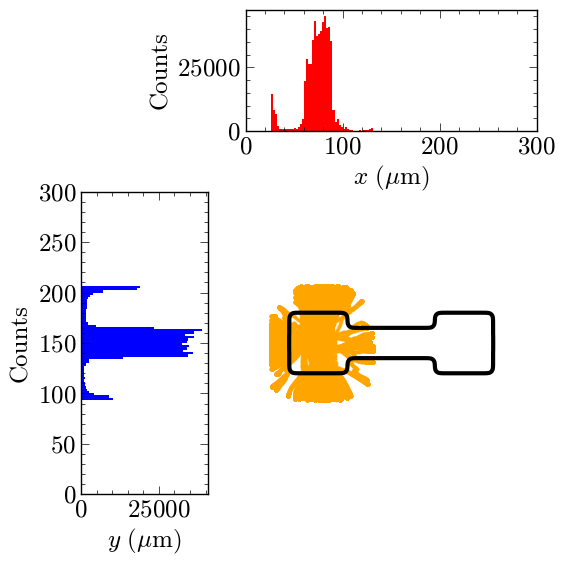

Eliminating 717 runs...
Ending up with 723 existing runs.


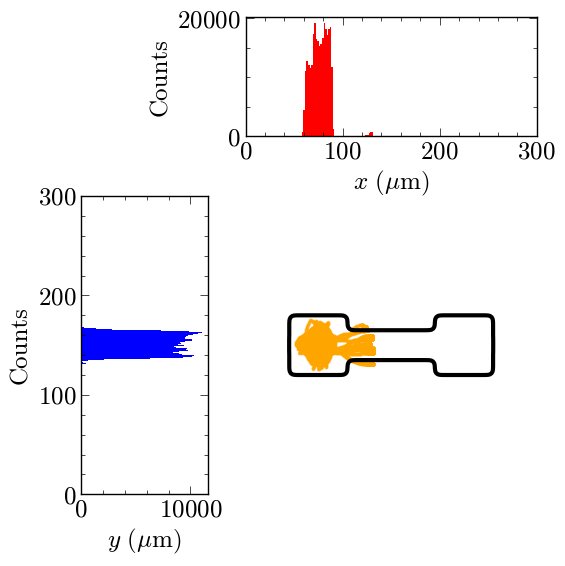

In [375]:
analysis.view_position_dist(global_pos, mu_factor)

# BOUNDS OF SUBSTRATE -- MUST CHANGE IF IT CHANGES
# OFFSET INWARD BY 5
escaped_df = global_pos.query("y > 175 or y < 125 or x > 250 or x < 50")
escaped_gids = escaped_df.gid.to_list()
escaped_runs = escaped_df.rid.to_list()
escaped_tups = sorted(list(set(zip(escaped_gids, escaped_runs))), key=lambda x: x[0])

def keep(df):
    print(f"Eliminating {len(escaped_tups)} runs...")
    print(f"Ending up with {df.shape[0] // 400 - len(escaped_tups)} existing runs.")
    df_temp = df.reset_index()

    for gid, rid in escaped_tups:
        drop_index = df_temp.query(f"gid=={gid} and rid=={rid}").index
        df_temp.drop(index=drop_index, inplace=True)
    
    return df_temp.set_index("index")

global_pos = keep(global_pos)
analysis.view_position_dist(global_pos, mu_factor)


### Hopping times

In [376]:
hop_times = []
df_HT = []
for (gid, rid), df in global_pos.groupby(["gid", "rid"]):
        t = analysis.get_hopping_times(df, mu_factor)
        [hop_times.append(el) for el in t]
        df_t = pd.DataFrame(t, columns=["t"])
        df_t["gid"] = gid
        df_t["rid"] = rid
        df_HT.append(df_t)

df_HT = pd.concat(df_HT)
df_HT


,t,gid,rid


/home/pedrom/miniconda3/envs/ccam/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


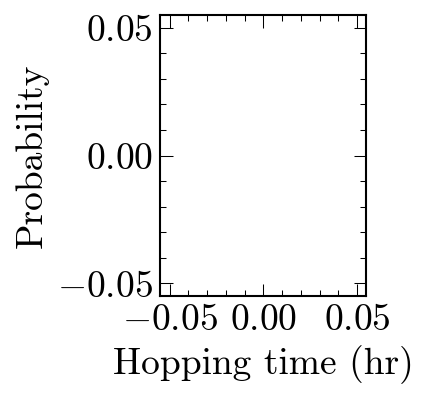

In [377]:
plt.figure(figsize=(3, 3), dpi=150)
plt.hist(np.array(df_HT.t), bins=40, color="red", alpha=0.5, density=True)
plt.xlabel("Hopping time (hr)")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

### Acceleration maps

In [378]:
global_x_v_a = []

for (gid, rid), df in global_pos.groupby(["gid", "rid"]):
    x_v_a = analysis.calc_v_a_from_position(df.x, dt)
    x_v_a["gid"] = gid
    x_v_a["rid"] = rid
    global_x_v_a.append(x_v_a)

global_x_v_a = pd.concat(global_x_v_a)
global_x_v_a


,x,v,a,gid,rid
0,75.000000,1.832027,19.790922,450,3
1,75.244270,4.470817,22.476328,450,3
2,75.840379,7.467660,9.834987,450,3
3,76.836067,8.778992,11.669493,450,3
4,78.006599,10.334924,-0.497483,450,3
...,...,...,...,...,...
393,75.536461,-11.237681,-2.376099,479,44
394,74.038103,-11.554494,6.222889,479,44
395,72.497504,-10.724776,6.367523,479,44
396,71.067534,-9.875773,11.460941,479,44


In [379]:
bounds = global_x_v_a.agg(["min", max])
xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]

nbins = 30
dx = (xmax - xmin) / nbins
dv = (vmax - vmin) / nbins

print(xmin, xmax)
print(vmin, vmax)

51.4729229775865 131.5231356162401
-13.435387255287523 13.470817629762344


In [380]:
x1 = ("x", xmin, dx)
x2 = ("v", vmin, dv)

analysis.get_bin_indices(global_x_v_a, nbins, x1, x2)
global_x_v_a

,x,v,a,gid,rid,x_bin,v_bin
0,75.000000,1.832027,19.790922,450,3,8,17
1,75.244270,4.470817,22.476328,450,3,8,19
2,75.840379,7.467660,9.834987,450,3,9,23
3,76.836067,8.778992,11.669493,450,3,9,24
4,78.006599,10.334924,-0.497483,450,3,9,26
...,...,...,...,...,...,...,...
393,75.536461,-11.237681,-2.376099,479,44,9,2
394,74.038103,-11.554494,6.222889,479,44,8,2
395,72.497504,-10.724776,6.367523,479,44,7,3
396,71.067534,-9.875773,11.460941,479,44,7,3


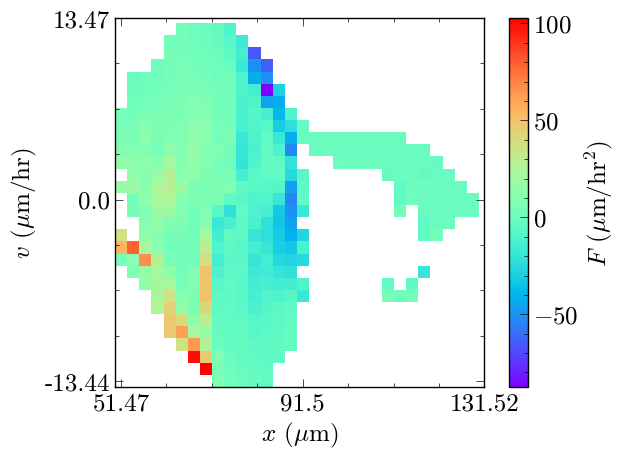

In [381]:
map_a = analysis.map_a(global_x_v_a, nbins, "x_bin", "v_bin")

from matplotlib.ticker import FormatStrFormatter

plt.imshow(map_a, origin="lower", interpolation="none", cmap="rainbow")
plt.xticks(
    [0, nbins // 2, nbins],
    [round(xmin, 2), round((xmin + xmax) / 2, 2), round(xmax, 2)],
)
plt.yticks(
    [0, nbins // 2, nbins], [round(vmin, 2), round((vmin + vmax) / 2, 0), round(vmax, 2)]
)
cbar = plt.colorbar()
cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()


### Streamlines

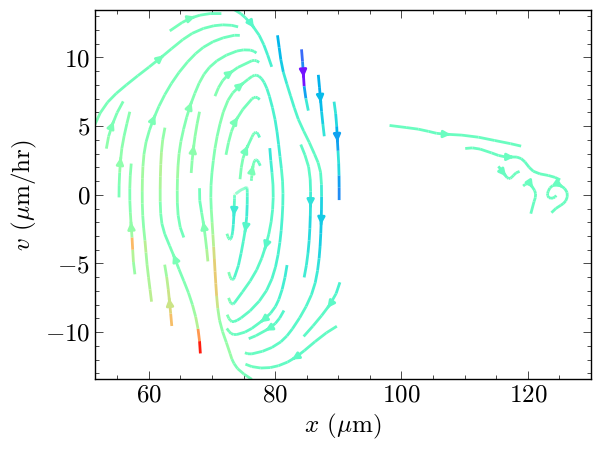

In [382]:
X, Y = np.meshgrid(np.linspace(xmin, xmax, nbins), np.linspace(vmin, vmax, nbins))

V = np.empty(X.shape)
V[:] = np.nan

for (j, i), df in global_x_v_a.groupby(["x_bin", "v_bin"]):
    a = df.a.mean()
    V[i, j] = a 

plt.streamplot(X, Y, Y, V, linewidth=2, color=V, cmap="rainbow")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()

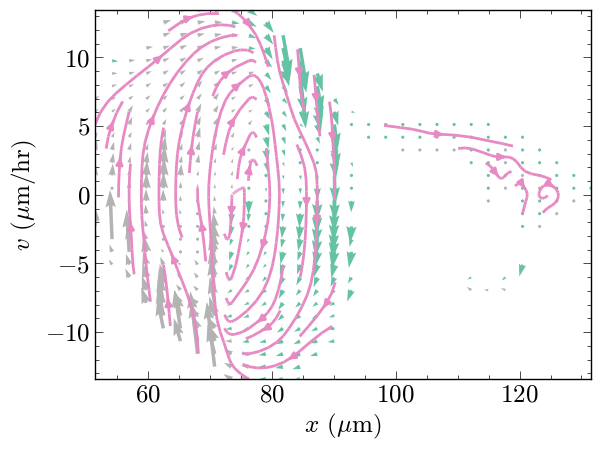

In [383]:
c = plt.get_cmap("Set2")(3)
plt.quiver(X, Y, Y, V, np.where(V>0, 1, 0), cmap="Set2", width=0.007)
plt.streamplot(X, Y, Y, V, linewidth=2, color=c)
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()

# Exploring some shit

In [384]:
print(f"Total simulation time (hours) = {(200000 * 0.002 * 8) / 60 :.2f}")
print(f"Dimension of substrate:\n   - {60} x {60} micron squares\n   - {30} micron bridge mouth\n   - ~ {100} micron bridge length")

Total simulation time (hours) = 53.33
Dimension of substrate:
   - 60 x 60 micron squares
   - 30 micron bridge mouth
   - ~ 100 micron bridge length


In [385]:
D = [0.01, 0.05, 0.1, 0.15, 0.2, 0.5]
D_RU = np.array(D) * 7.5
tau = 1/D_RU
print(f"Diffusion coeff in rad^2 / hr: {D_RU}")
print(f"Persistence time in hr: {tau}")


Diffusion coeff in rad^2 / hr: [0.075 0.375 0.75  1.125 1.5   3.75 ]
Persistence time in hr: [13.33333333  2.66666667  1.33333333  0.88888889  0.66666667  0.26666667]


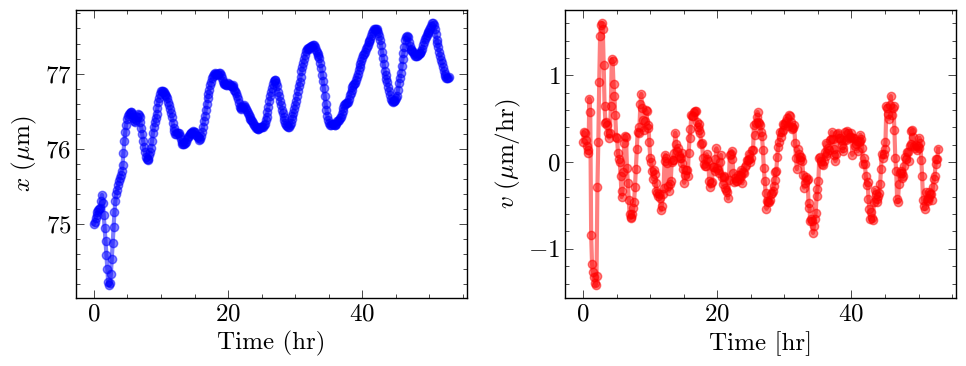

In [386]:
del df
x = []
v = []

for (gid, rid), df in global_x_v_a.groupby(["gid", "rid"]):
    x.append(df.x.to_numpy())
    v.append(df.v.to_numpy())

x = np.mean(x, axis=0)
v = np.mean(v, axis=0)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(df.index * dt, x, "-o", lw=3, color="blue", alpha=0.5)
plt.xlabel("Time (hr)")
plt.ylabel(r"$x\ (\mu$m)")
plt.subplot(122)
plt.plot(df.index * dt, v, "-o", lw=3, color="red", alpha=0.5)
plt.xlabel("Time [hr]")
plt.ylabel(r"$v\ (\mu$m/hr)")

plt.tight_layout()
plt.show()
